# Proyecto 2
# Procesamiento de Lenguaje Natural basados en arquitecturas neuronales secuenciales.

## Librerias

In [23]:
import os
import re
import pandas as pd
import spacy
import random

## Preparación del Corpus

In [24]:
# Descargar el modelo de spaCy para español si no está ya descargado
# python -m spacy download es_core_news_sm

# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

# Rutas
RAW_PATH = "Data/raw_corpus.txt"          # entrada
OUT_DIR = "Data/processed"                # carpeta de salida

os.makedirs(OUT_DIR, exist_ok=True)

# Cargar el texto bruto
with open(RAW_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Longitud del texto bruto:", len(raw_text))
print(raw_text[:500])  # muestra un fragmento

Longitud del texto bruto: 3975
Érase un pobre campesino que estaba una noche junto al hogar atizando el fuego, mientras su mujer hilaba, sentada a su lado.

Dijo el hombre: – ¡Qué triste es no tener hijos! ¡Qué silencio en esta casa, mientras en las otras todo es ruido y alegría! – Sí -respondió la mujer, suspirando-. Aunque fuese uno solo, y aunque fuese pequeño como el pulgar, me daría por satisfecha. Lo querríamos más que nuestra vida.

Sucedió que la mujer se sintió descompuesta, y al cabo de siete meses trajo al mundo un


### Limpieza básica

In [25]:
def clean_text(text: str) -> str:
    # Normalizar saltos de línea: quitar espacios antes de saltos
    text = re.sub(r"[ \t]+\n", "\n", text)

    # Normalizar comillas curvas a comillas rectas (opcional)
    text = text.replace("“", "\"").replace("”", "\"").replace("’", "'").replace("‘", "'")
    
    # Unificar guiones largos de diálogo (si aparecen variantes)
    text = text.replace("—", "–")
    
    # Quitar espacios repetidos
    text = re.sub(r"[ \t]+", " ", text)
    
    # Quitar saltos de línea múltiples excesivos (más de 2)
    text = re.sub(r"\n{3,}", "\n\n", text)
    
    # Strip global
    text = text.strip()
    return text

clean_corpus = clean_text(raw_text)

print("Longitud del texto limpio:", len(clean_corpus))
print(clean_corpus[:500])

Longitud del texto limpio: 3975
Érase un pobre campesino que estaba una noche junto al hogar atizando el fuego, mientras su mujer hilaba, sentada a su lado.

Dijo el hombre: – ¡Qué triste es no tener hijos! ¡Qué silencio en esta casa, mientras en las otras todo es ruido y alegría! – Sí -respondió la mujer, suspirando-. Aunque fuese uno solo, y aunque fuese pequeño como el pulgar, me daría por satisfecha. Lo querríamos más que nuestra vida.

Sucedió que la mujer se sintió descompuesta, y al cabo de siete meses trajo al mundo un


In [26]:
# Guardar el texto limpio
clean_corpus_path = os.path.join(OUT_DIR, "clean_corpus.txt").replace("\\", "/")
with open(clean_corpus_path, "w", encoding="utf-8") as f:
    f.write(clean_corpus)

print(f"Texto limpio guardado en: {clean_corpus_path}")

Texto limpio guardado en: Data/processed/clean_corpus.txt


### Tokenizacion y Segmentacion en oraciones

In [27]:
# Procesar todo el corpus con spaCy
doc = nlp(clean_corpus)

sentences = []
tokens_per_sentence = []

for sent in doc.sents:
    sent_text = sent.text.strip()
    if not sent_text:
        continue
    
    # Lista de tokens de la oración, sin espacios
    toks = [tok.text for tok in sent if not tok.is_space]
    
    # Filtramos oraciones muy cortas si quieres (opcional)
    if len(toks) == 0:
        continue
    
    sentences.append(sent_text)
    tokens_per_sentence.append(toks)

print("Número de oraciones detectadas:", len(sentences))
for i in range(min(5, len(sentences))):
    print(f"\nOración {i}: {sentences[i]}")
    print("Tokens:", tokens_per_sentence[i])


Número de oraciones detectadas: 41

Oración 0: Érase un pobre campesino que estaba una noche junto al hogar atizando el fuego, mientras su mujer hilaba, sentada a su lado.
Tokens: ['Érase', 'un', 'pobre', 'campesino', 'que', 'estaba', 'una', 'noche', 'junto', 'al', 'hogar', 'atizando', 'el', 'fuego', ',', 'mientras', 'su', 'mujer', 'hilaba', ',', 'sentada', 'a', 'su', 'lado', '.']

Oración 1: Dijo el hombre: – ¡Qué triste es no tener hijos! ¡Qué silencio en esta casa, mientras en las otras todo es ruido y alegría! –
Tokens: ['Dijo', 'el', 'hombre', ':', '–', '¡', 'Qué', 'triste', 'es', 'no', 'tener', 'hijos', '!', '¡', 'Qué', 'silencio', 'en', 'esta', 'casa', ',', 'mientras', 'en', 'las', 'otras', 'todo', 'es', 'ruido', 'y', 'alegría', '!', '–']

Oración 2: Sí -respondió la mujer, suspirando-.
Tokens: ['Sí', '-respondió', 'la', 'mujer', ',', 'suspirando-', '.']

Oración 3: Aunque fuese uno solo, y aunque fuese pequeño como el pulgar, me daría por satisfecha.
Tokens: ['Aunque', 'fuese',

In [28]:
tokenized_sentences_str = [" ".join(toks) for toks in tokens_per_sentence]

data_df = pd.DataFrame({
    "id": list(range(len(sentences))),
    "sentence": sentences,
    "tokens": tokenized_sentences_str
})

all_sentences_path = os.path.join(OUT_DIR, "sentences_tokenized_spacy.csv").replace("\\", "/")
data_df.to_csv(all_sentences_path, index=False, encoding="utf-8")
print(f"Datos tokenizados guardados en: {all_sentences_path}")


Datos tokenizados guardados en: Data/processed/sentences_tokenized_spacy.csv


### División de entrenamiento, validación y prueba

In [29]:
indices = list(range(len(data_df)))
random.shuffle(indices)

n_total = len(indices)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

train_df = data_df.iloc[train_idx].reset_index(drop=True)
val_df = data_df.iloc[val_idx].reset_index(drop=True)
test_df = data_df.iloc[test_idx].reset_index(drop=True)

print("Tamaños:")
print("train:", len(train_df))
print("val:  ", len(val_df))
print("test: ", len(test_df))

train_path = os.path.join(OUT_DIR, "train_sentences_spacy.csv").replace("\\", "/")
val_path = os.path.join(OUT_DIR, "val_sentences_spacy.csv").replace("\\", "/")
test_path = os.path.join(OUT_DIR, "test_sentences_spacy.csv").replace("\\", "/")

train_df.to_csv(train_path, index=False, encoding="utf-8")
val_df.to_csv(val_path, index=False, encoding="utf-8")
test_df.to_csv(test_path, index=False, encoding="utf-8")

print("\nConjuntos guardados en:")
print("- Train:", train_path)
print("- Validation:", val_path)
print("- Test:", test_path)

Tamaños:
train: 32
val:   4
test:  5

Conjuntos guardados en:
- Train: Data/processed/train_sentences_spacy.csv
- Validation: Data/processed/val_sentences_spacy.csv
- Test: Data/processed/test_sentences_spacy.csv


## Modelos Secuenciales

### Red Neuronal Recurrente (RNN)

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

#### Construcción del vocabulario y secuencias numéricas

In [31]:
train_path = os.path.join(OUT_DIR, "train_sentences_spacy.csv").replace("\\", "/")
val_path = os.path.join(OUT_DIR, "val_sentences_spacy.csv").replace("\\", "/")

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

print(train_df.head())

   id                                           sentence  \
0  29  -Y, dirigiéndose al leñador, dijeron: – Venden...   
1   4  Lo querríamos más que nuestra vida.\n\nSucedió...   
2  22                        – ¡Aquí hay algún misterio!   
3  24               Sigamos el carro y veamos adónde va.   
4   3  Aunque fuese uno solo, y aunque fuese pequeño ...   

                                              tokens  
0  -Y , dirigiéndose al leñador , dijeron : – Ven...  
1  Lo querríamos más que nuestra vida . Sucedió q...  
2                      – ¡ Aquí hay algún misterio !  
3              Sigamos el carro y veamos adónde va .  
4  Aunque fuese uno solo , y aunque fuese pequeño...  


In [32]:
def build_vocab(token_series, min_freq=1):
    """
    Construye el vocabulario a partir de una serie de pandas que contiene oraciones tokenizadas como strings.
    Args:
        token_series (pd.Series): Serie de pandas con oraciones tokenizadas como strings.
        min_freq (int): Frecuencia mínima para incluir un token en el vocabulario.  
    Returns:
        stoi (dict): Mapeo de token a índice.
        itos (list): Lista de tokens en orden de índice.
    """
    counter = Counter()
    for row in token_series:
        tokens = str(row).split()
        counter.update(tokens)
    
    # Tokens especiales
    stoi = {"<PAD>": 0, "<UNK>": 1}
    itos = ["<PAD>", "<UNK>"]
    
    for tok, freq in counter.items():
        if freq >= min_freq:
            stoi[tok] = len(itos)
            itos.append(tok)
    
    return stoi, itos

stoi, itos = build_vocab(train_df["tokens"], min_freq=1)
vocab_size = len(itos)
print("Tamaño del vocabulario:", vocab_size)
print("Ejemplo de tokens:", itos[:30])

Tamaño del vocabulario: 329
Ejemplo de tokens: ['<PAD>', '<UNK>', '-Y', ',', 'dirigiéndose', 'al', 'leñador', 'dijeron', ':', '–', 'Vendenos', 'este', 'hombrecillo', 'lo', 'pasará', 'bien', 'con', 'nosotros', '.', 'Lo', 'querríamos', 'más', 'que', 'nuestra', 'vida', 'Sucedió', 'la', 'mujer', 'se', 'sintió']


#### Construcción de secuencias para predicción de siguiente palabra

In [33]:
def tokens_to_ids(tokens_str, stoi):
    return [stoi.get(tok, stoi["<UNK>"]) for tok in str(tokens_str).split()]

# Convertir todo el train a una sola lista de índices
train_ids = []
for row in train_df["tokens"]:
    train_ids.extend(tokens_to_ids(row, stoi))

val_ids = []
for row in val_df["tokens"]:
    val_ids.extend(tokens_to_ids(row, stoi))

print("Longitud total de train_ids:", len(train_ids))
print("Ejemplo de ids:", train_ids[:20])

Longitud total de train_ids: 711
Ejemplo de ids: [2, 3, 4, 5, 6, 3, 7, 8, 9, 10, 11, 12, 3, 13, 14, 15, 16, 17, 18, 19]


In [34]:
SEQ_LEN = 10

def build_sequences(id_list, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(id_list) - seq_len):
        X.append(id_list[i:i+seq_len])
        y.append(id_list[i+seq_len])
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

X_train, y_train = build_sequences(train_ids, SEQ_LEN)
X_val, y_val = build_sequences(val_ids, SEQ_LEN)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: torch.Size([701, 10])
y_train shape: torch.Size([701])


#### Dataset y DataLoader

In [35]:
class NextWordDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NextWordDataset(X_train, y_train)
val_dataset = NextWordDataset(X_val, y_val)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


#### Definición del modelo RNN

In [36]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        # x: (batch, seq_len)
        emb = self.embedding(x)               # (batch, seq_len, embed_dim)
        out, hidden = self.rnn(emb, hidden)   # out: (batch, seq_len, hidden_dim)
        # Tomamos la última salida de la secuencia
        last_out = out[:, -1, :]              # (batch, hidden_dim)
        logits = self.fc(last_out)            # (batch, vocab_size)
        return logits, hidden

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNLanguageModel(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

RNNLanguageModel(
  (embedding): Embedding(329, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=329, bias=True)
)


#### Entrenamiento de la RNN

In [37]:
EPOCHS = 20
train_losses = []
val_losses = []

def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits, _ = model(X_batch)
            loss = criterion(logits, y_batch)
            batch_size = y_batch.size(0)
            total_loss += loss.item() * batch_size
            total_tokens += batch_size
    return total_loss / total_tokens

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    total_tokens = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size
        total_tokens += batch_size
    
    train_loss = total_loss / total_tokens
    val_loss = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    
    print(f"[RNN] Epoch {epoch}/{EPOCHS} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")


[RNN] Epoch 1/20 | Train loss: 5.8221 | Val loss: 5.7387
[RNN] Epoch 2/20 | Train loss: 5.4458 | Val loss: 5.6666
[RNN] Epoch 3/20 | Train loss: 5.0989 | Val loss: 5.5902
[RNN] Epoch 4/20 | Train loss: 4.7457 | Val loss: 5.5681
[RNN] Epoch 5/20 | Train loss: 4.4031 | Val loss: 5.5354
[RNN] Epoch 6/20 | Train loss: 4.0916 | Val loss: 5.5305
[RNN] Epoch 7/20 | Train loss: 3.8064 | Val loss: 5.4960
[RNN] Epoch 8/20 | Train loss: 3.5350 | Val loss: 5.4943
[RNN] Epoch 9/20 | Train loss: 3.2683 | Val loss: 5.4544
[RNN] Epoch 10/20 | Train loss: 3.0176 | Val loss: 5.4155
[RNN] Epoch 11/20 | Train loss: 2.7733 | Val loss: 5.4189
[RNN] Epoch 12/20 | Train loss: 2.5459 | Val loss: 5.4072
[RNN] Epoch 13/20 | Train loss: 2.3305 | Val loss: 5.4439
[RNN] Epoch 14/20 | Train loss: 2.1249 | Val loss: 5.4241
[RNN] Epoch 15/20 | Train loss: 1.9314 | Val loss: 5.4200
[RNN] Epoch 16/20 | Train loss: 1.7545 | Val loss: 5.4509
[RNN] Epoch 17/20 | Train loss: 1.5833 | Val loss: 5.4661
[RNN] Epoch 18/20 | Tra

#### Prueba cualitativa: predicción de la siguiente palabra

In [38]:
def ids_to_tokens(ids, itos):
    return [itos[i] for i in ids]

def predict_next_word(model, prompt_tokens, stoi, itos, top_k=5):
    model.eval()
    # Convertir tokens a ids
    ids = [stoi.get(tok, stoi["<UNK>"]) for tok in prompt_tokens]
    # Asegurar longitud SEQ_LEN (truncar o padear al inicio con <PAD>)
    if len(ids) < SEQ_LEN:
        ids = [stoi["<PAD>"]] * (SEQ_LEN - len(ids)) + ids
    else:
        ids = ids[-SEQ_LEN:]
    
    x = torch.tensor([ids], dtype=torch.long).to(device)
    with torch.no_grad():
        logits, _ = model(x)
        probs = torch.softmax(logits[0], dim=-1)
        top_probs, top_ids = torch.topk(probs, k=top_k)
    
    candidates = [(itos[top_ids[i].item()], top_probs[i].item()) for i in range(top_k)]
    return candidates

prompt = ["Pulgarcito", "dijo", "al", "padre", "que"]
candidates = predict_next_word(model, prompt, stoi, itos, top_k=5)

print("Prompt:", " ".join(prompt))
print("Siguientes palabras más probables:")
for w, p in candidates:
    print(f"{w}\t{p:.4f}")


Prompt: Pulgarcito dijo al padre que
Siguientes palabras más probables:
vaya	0.0720
seguía	0.0650
eres	0.0542
les	0.0517
nuestra	0.0449


#### Gráficos

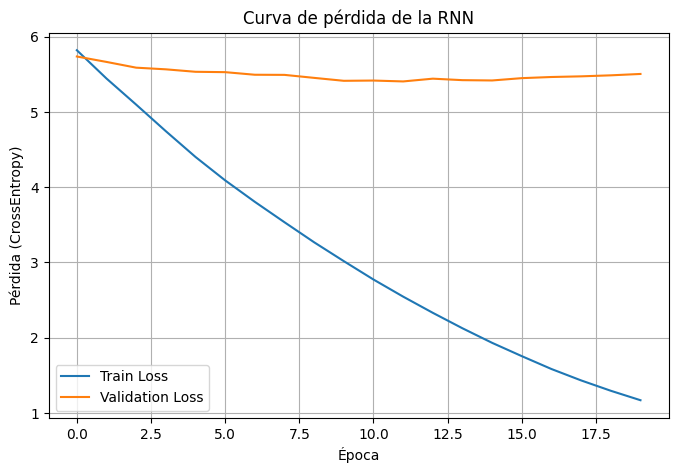

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida (CrossEntropy)")
plt.title("Curva de pérdida de la RNN")
plt.legend()
plt.grid(True)
plt.show()

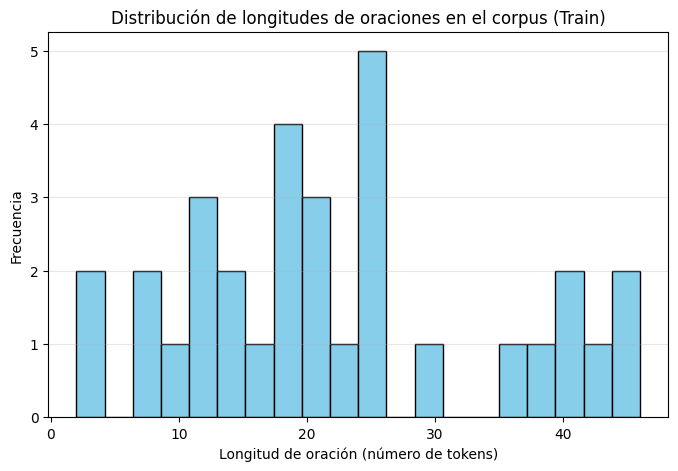

In [40]:
sentence_lengths = [len(toks.split()) for toks in train_df["tokens"]]

plt.figure(figsize=(8, 5))
plt.hist(sentence_lengths, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Longitud de oración (número de tokens)")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes de oraciones en el corpus (Train)")
plt.grid(axis="y", alpha=0.3)
plt.show()

### Modelo LSTM (Long Short-Term Memory)

In [41]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        emb = self.embedding(x)           # (batch, seq_len, embed_dim)
        out, hidden = self.lstm(emb)      # (batch, seq_len, hidden_dim)
        last_out = out[:, -1, :]          # tomamos solo la última salida
        logits = self.fc(last_out)        # (batch, vocab_size)
        return logits, hidden

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=128,
    num_layers=2,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

print(lstm_model)

LSTMLanguageModel(
  (embedding): Embedding(329, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=329, bias=True)
)


#### Entrenamiento de la LSTM

In [43]:
EPOCHS_LSTM = 20
train_losses_lstm = []
val_losses_lstm = []

def evaluate_lstm(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits, _ = model(X_batch)
            loss = criterion(logits, y_batch)
            batch_size = y_batch.size(0)
            total_loss += loss.item() * batch_size
            total_tokens += batch_size
    return total_loss / total_tokens


for epoch in range(1, EPOCHS_LSTM + 1):
    lstm_model.train()
    total_loss = 0.0
    total_tokens = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits, _ = lstm_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size
        total_tokens += batch_size

    train_loss = total_loss / total_tokens
    val_loss = evaluate_lstm(lstm_model, val_loader)

    train_losses_lstm.append(train_loss)
    val_losses_lstm.append(val_loss)

    print(f"[LSTM] Epoch {epoch}/{EPOCHS_LSTM} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

[LSTM] Epoch 1/20 | Train loss: 5.7870 | Val loss: 5.7304
[LSTM] Epoch 2/20 | Train loss: 5.5835 | Val loss: 5.5033
[LSTM] Epoch 3/20 | Train loss: 5.2351 | Val loss: 5.7295
[LSTM] Epoch 4/20 | Train loss: 5.1256 | Val loss: 5.8033
[LSTM] Epoch 5/20 | Train loss: 5.0492 | Val loss: 5.9495
[LSTM] Epoch 6/20 | Train loss: 4.9361 | Val loss: 5.9977
[LSTM] Epoch 7/20 | Train loss: 4.7916 | Val loss: 6.0195
[LSTM] Epoch 8/20 | Train loss: 4.6133 | Val loss: 6.0151
[LSTM] Epoch 9/20 | Train loss: 4.4333 | Val loss: 6.0865
[LSTM] Epoch 10/20 | Train loss: 4.2441 | Val loss: 6.0846
[LSTM] Epoch 11/20 | Train loss: 4.0561 | Val loss: 6.1010
[LSTM] Epoch 12/20 | Train loss: 3.8579 | Val loss: 6.1121
[LSTM] Epoch 13/20 | Train loss: 3.6580 | Val loss: 6.1590
[LSTM] Epoch 14/20 | Train loss: 3.4625 | Val loss: 6.1322
[LSTM] Epoch 15/20 | Train loss: 3.2867 | Val loss: 6.2503
[LSTM] Epoch 16/20 | Train loss: 3.0891 | Val loss: 6.2391
[LSTM] Epoch 17/20 | Train loss: 2.8992 | Val loss: 6.2718
[LSTM]

#### Gráfica: Pérdida (Train vs Validation) – LSTM

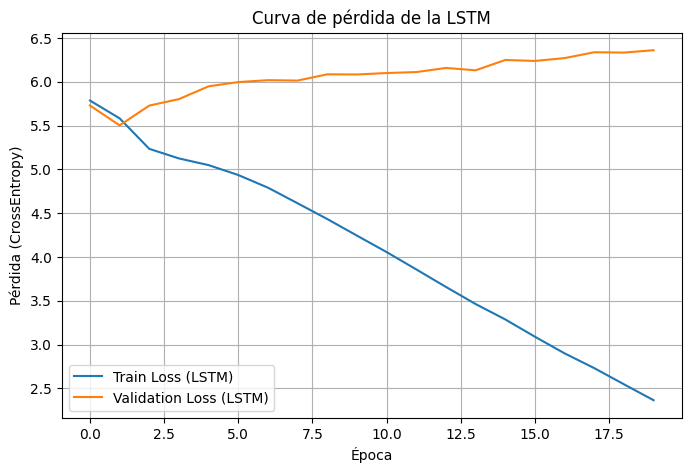

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses_lstm, label="Train Loss (LSTM)")
plt.plot(val_losses_lstm, label="Validation Loss (LSTM)")
plt.xlabel("Época")
plt.ylabel("Pérdida (CrossEntropy)")
plt.title("Curva de pérdida de la LSTM")
plt.legend()
plt.grid(True)
plt.show()